In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import warnings
from datetime import datetime
warnings.filterwarnings('ignore') 

# Update rcParams in mpl
rcParams = {
        'font.size': 20,                # all fonts-size in plot
        'font.weight': 'bold',          # bold all fonts
        'figure.titleweight': 'bold',   # bold supertitle
        'axes.linewidth' : 6,
        'xtick.major.width': 6,
        'axes.spines.top': True,
        'axes.spines.right': True,
        'lines.linewidth': 6,
        'legend.fontsize': 'large',
        'xtick.labelsize': 'large',
        'ytick.labelsize': 'large',
        'xtick.labelsize': 20,   # sets x-tick font size
        'ytick.labelsize': 20,
        'axes.titlepad': 20,   # spacing between suptitle and figure
        'axes.facecolor': 'white'
    }
# Update rcparams
mpl.rcParams.update(rcParams) 

In [2]:
df = pd.read_csv("doe363_125_currenterror.csv",
usecols = ['doe', 'instance', 'cycle_num','charging_state_name',
 'elapsed_minutes', 'cccv_state', 'avg_current_a']).query("charging_state_name == 'CHARGE'")\
.dropna(subset = 'avg_current_a').reset_index(drop = True)

<Axes: xlabel='elapsed_minutes', ylabel='avg_current_a'>

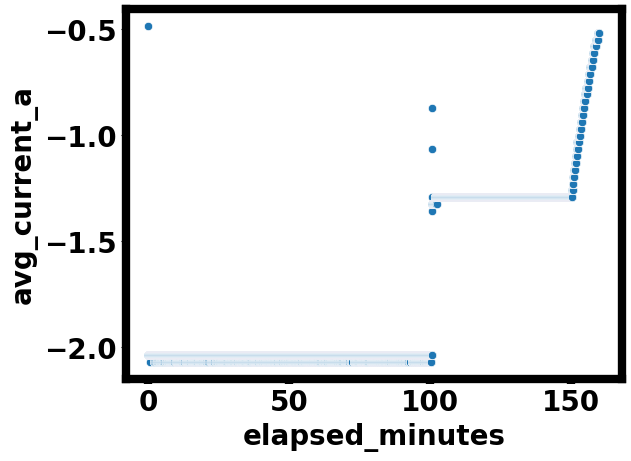

In [3]:
sns.scatterplot(df[df['cycle_num'] == 4], x= 'elapsed_minutes', y = 'avg_current_a')

In [4]:
# Define error limits for each current range
error_limits = {
    (-1.0, 0.0): 8.0,        # 8% error for -1 <= avg_current_a < 0.0 A
    (-1.5, -1.0): 2.0,       # 2% error for -1.5 <= avg_current_a < -1.0 A
    (-3.0, -1.5): 1.5,     # 1.5% error -3.0 <= avg_current_a < -1.0 A
    (-np.inf, -3.0): 1.0    # 1% error -np.inf <= avg_current_a < -3.0 A
}
adc_tick = 0.000   # 32.5 mA

bins = [-np.inf] + [key[1] for key in error_limits.keys()][::-1]
error_percentages = list(error_limits.values())[::-1]

# Use pd.cut to categorize the current column into bins
df['error_pc'] = pd.cut(df['avg_current_a'], bins = bins, labels = error_percentages, include_lowest = True).astype(float)

df['avg_current_a_lower_bound'] = (df['avg_current_a'] * (1 + (df['error_pc'] * 0.01))) + adc_tick

df['avg_current_a_upper_bound'] = df['avg_current_a'] * (1 - (df['error_pc'] * 0.01)) - adc_tick

df['capacity_lower_bound'] = (df.groupby(['doe', 'instance', 'cycle_num']).apply(lambda group: 
(-group['avg_current_a_lower_bound'] * group['elapsed_minutes'].diff()).cumsum()).values)/60

df['capacity'] = (df.groupby(['doe', 'instance', 'cycle_num']).apply(lambda group: 
(-group['avg_current_a'] * group['elapsed_minutes'].diff()).cumsum()).values)/60

df['capacity_upper_bound'] = (df.groupby(['doe', 'instance', 'cycle_num']).apply(lambda group: 
(-group['avg_current_a_upper_bound'] * group['elapsed_minutes'].diff()).cumsum()).values)/60

In [5]:
# calculate median and std time
filter_column = 'capacity'
filter_df = df.groupby(['doe', 'instance', 'cycle_num'])[filter_column].max().reset_index()
sigma_multiplier = 3.0
std_column = filter_df[filter_column].std(ddof = 1)
median_column = filter_df[filter_column].median()

# time bounds 
column_bounds = (median_column - sigma_multiplier * std_column, median_column + sigma_multiplier * std_column)

# Identify the cycle num to drop based on time bounds
drop_cycles = filter_df[~(filter_df[filter_column].between(column_bounds[0], column_bounds[1]))]['cycle_num'].unique()

In [6]:
# If drop cycle appear based on capacity means they might have been cycled twice
df = df[~df['cycle_num'].isin(drop_cycles)]

In [7]:
df_breakdown = df.groupby(['doe', 'instance', 'cycle_num', 'error_pc'])\
.apply(lambda group: pd.Series({"time_min": group['elapsed_minutes'].nlargest(10).median() - group['elapsed_minutes'].nsmallest(10).median(),
            "capacity_upper": group['capacity_upper_bound'].nlargest(10).median() - group['capacity_upper_bound'].nsmallest(10).median(),
            "capacity": group['capacity'].nlargest(10).median() - group['capacity'].nsmallest(10).median(),
            "capacity_lower": group['capacity_lower_bound'].nlargest(10).median() - group['capacity_lower_bound'].nsmallest(10).median()
            })).reset_index()


In [8]:
df_breakdown['time_pc'] = (df_breakdown['time_min'] * 100)/df_breakdown.groupby(['doe', 'instance', 'cycle_num'])['time_min'].transform(sum)
df_breakdown['capacity_pc'] = (df_breakdown['capacity'] * 100)/df_breakdown.groupby(['doe', 'instance', 'cycle_num'])['capacity'].transform(sum)

In [9]:
df_breakdown

,doe,instance,cycle_num,error_pc,time_min,capacity_upper,capacity,capacity_lower,time_pc,capacity_pc,capacity_unceratinty_pc
0,363,125,4,1.5,100.690292,3.371688,3.423034,3.474379,62.999971,74.025239,-3.000000
1,363,125,4,2.0,52.220300,1.095522,1.117880,1.140237,32.673233,24.174848,-4.000000
2,363,125,4,8.0,6.915342,0.076572,0.083231,0.089889,4.326796,1.799913,-16.000000
3,363,125,8,1.5,101.488900,3.397981,3.449727,3.501473,63.406755,74.357544,-3.000000
4,363,125,8,2.0,51.765133,1.086325,1.108495,1.130665,32.341065,23.893186,-4.000000
...,...,...,...,...,...,...,...,...,...,...,...
184,363,125,248,2.0,52.558358,1.100784,1.123249,1.145714,33.994256,25.400437,-4.000000
185,363,125,248,8.0,7.779142,0.086536,0.094051,0.101567,5.031476,2.126816,-15.981964
186,363,125,252,1.5,92.954192,3.112453,3.159851,3.207249,61.532811,73.060653,-3.000000
187,363,125,252,2.0,49.980308,1.045921,1.067267,1.088612,33.085424,24.676860,-4.000000


In [11]:
def drop_outliers(df, column = 'capacity', sigma_multiplier = 3.0):
    median = df['capacity'].median()
    stdev = df['capacity'].std(ddof = 0)
    return df[(df[column] >= (median - sigma_multiplier * stdev)) & (df[column] <= (median + sigma_multiplier * stdev))]


df_cycloid = df.groupby(['doe', 'instance', 
'cycle_num']).agg({'capacity': 'max', 'capacity_lower_bound': 'max', 'capacity_upper_bound': 'max'}).reset_index()

df_cycloid = df_cycloid.groupby(['doe', 'instance']).apply(lambda group: drop_outliers(group)).reset_index(drop = True)

df_cycloid['capacity_lower_bound_pc'] = (df_cycloid['capacity_lower_bound'] * 100/df_cycloid['capacity']).round(2).astype(str) + '%'
df_cycloid['capacity_upper_bound_pc'] = (df_cycloid['capacity_upper_bound'] * 100/df_cycloid['capacity']).round(2).astype(str) + '%'
df_cycloid['capacity_uncertainty_pc'] = ((df_cycloid['capacity_upper_bound'] - df_cycloid['capacity_lower_bound']) 
* 100/df_cycloid['capacity']).round(2).astype(str) + '%'


Text(0.5, 1.0, 'DoE363_125 Error Bounds for Charge Capacity @ Cycle 4')

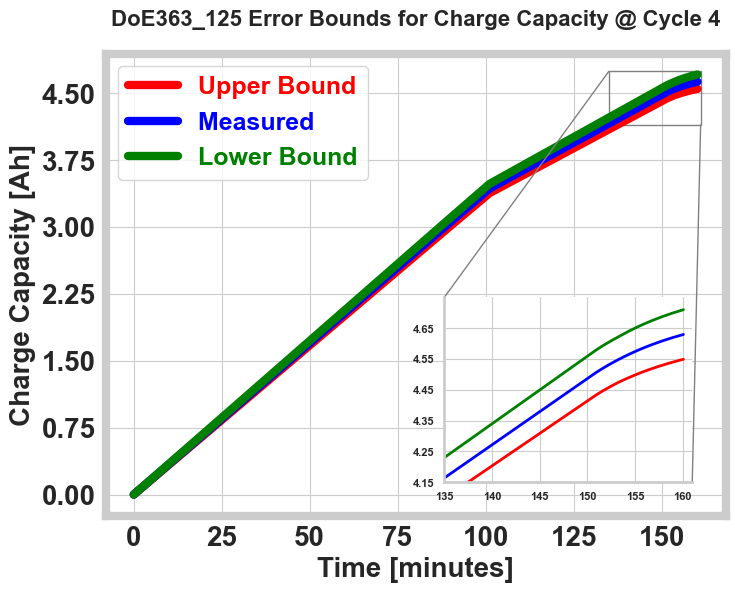

In [12]:
test = df[df['cycle_num'] == 4]
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
sns.set_style("whitegrid")

# Main plot
fig, ax = plt.subplots(figsize = (8, 6))
for col, color, label in zip(['capacity_upper_bound', 'capacity', 'capacity_lower_bound'], ['red', 'blue', 'green'], ['Upper Bound', 'Measured  ', 'Lower Bound']):
        sns.lineplot(data = test, x = 'elapsed_minutes', y = col, color = color, label = label)
ax.set_xticks(np.arange(0, 160, 25))
ax.set_yticks(np.arange(0, 4.6, 0.75))
ax.set_xlabel("Time [minutes]")
ax.set_ylabel("Charge Capacity [Ah]")
ax.legend(labelcolor = 'linecolor', loc = 'upper left', prop={'size': 18})

# Inset plot
ax_inset = inset_axes(ax, width = '40%', height = '40%', loc = 'lower right', borderpad = 1)
for col, color in zip(['capacity_upper_bound', 'capacity', 'capacity_lower_bound'], ['red', 'blue', 'green']):
        sns.lineplot(data = test, x = 'elapsed_minutes', y = col, color = color, linewidth = 2.0)
ax_inset.set_ylim([4.15, 4.75])
ax_inset.set_xlim([135, 161])
ax_inset.set_xticks(np.arange(135, 161, 5))
ax_inset.set_yticks(np.arange(4.15, 4.75, 0.1))
ax_inset.tick_params(axis = 'both', which = 'major', labelsize = 8)
ax_inset.set_xlabel(None)
ax_inset.set_ylabel(None)
ax_inset.spines[['top', 'right']].set_visible(False)

# set the spine borderwidth to be very small
for spine in ax_inset.spines.values():
        spine.set_linewidth(2.0)

# mark where the inset is to zoomed portion
mark_inset(ax, ax_inset, loc1 = 2, loc2 = 4, fc = "none", ec = "0.5")

ax.set_title("DoE363_125 Error Bounds for Charge Capacity @ Cycle 4", fontweight = 'bold', fontsize = 16)

## For time estimation just choose error pc 8.0 range

In [13]:
def time_uncertainty(df: pd.DataFrame, cut_off_current: float = -0.5, 
    current_error_pc: float = 8.0, adc_tick: float = 0.0325) -> pd.DataFrame:
    # Define lower and upper current bounds with error limiy accounting 1 ADC tick

    # Define cut_off_current as min(max(avg_current_a), cut_off_current) for each group
    cut_off_current_bounds = ((cut_off_current * (100 - current_error_pc) * 0.01) - adc_tick, 
    (cut_off_current * (100 + current_error_pc) * 0.01) + adc_tick)
    # Get the data for only CV period
    data = df[df['cccv_state'].eq(2)].reset_index(drop = True)
    
    lower = (100 - current_error_pc) * 0.01
    upper = (100 + current_error_pc) * 0.01


    charge_time_err = data.groupby(['doe', 'instance', 'cycle_num']).apply(
        lambda group: pd.Series(
            {'avg_current_a_cut_off': -0.50000,
            'charge_time': group['elapsed_minutes'].max(),
            'avg_current_lower_bound': -0.5 * upper,
            'charge_time_lower_bound': group.loc[(group['avg_current_a'] - (group['avg_current_a'].max() * upper)).abs().idxmin(), 'elapsed_minutes'],
            'avg_current_below_delta_time': group.loc[
            ((group['elapsed_minutes'] -
            (group.loc[(group['avg_current_a'] - (-0.5 * upper)).abs().idxmin(), 'elapsed_minutes'] -
            (group['elapsed_minutes'].max() - group.loc[(group['avg_current_a'] - (-0.5 * upper)).abs().idxmin(), 'elapsed_minutes']))))
            .abs().idxmin(), 'avg_current_a']
            }
        )
    ).reset_index()

    charge_time_err['charge_time_uncertainty'] = ((2 * (charge_time_err['charge_time'] - charge_time_err['charge_time_lower_bound'])\
    * 100)/(charge_time_err['charge_time'])).round(decimals = 2).astype(str) + '%'

    return charge_time_err


In [ ]:
import pandas as pd
import numpy as np
from dataclasses import dataclass, field
from typing import Dict, Union
import json

@dataclass
class CapacityTimeUncertainty:
    data: Union[pd.DataFrame, str]
    json_params: str = 'params.json'
    df: pd.DataFrame = field(init=False)
    params: Dict[str, Union[float, Dict[str, float]]] = field(init=False)

    def __post_init__(self):
        self.load_params()
        self.load_data()

    def load_params(self):
        with open(self.json_params, 'r') as file:
            self.params = json.load(file)

    def load_data(self):
        if isinstance(self.data, str):
            if self.data.endswith('.csv'):
                self.df = pd.read_csv(self.data)
            elif self.data.endswith('.xlsx'):
                self.df = pd.read_excel(self.data)
            else:
                raise ValueError("Unsupported file type")
        else:
            self.df = self.data
        
        self.df = self.df.query("charging_state_name == 'CHARGE'").dropna(subset=['avg_current_a']).reset_index(drop=True)
        self.apply_error_limits()

    def apply_error_limits(self):
        error_limits = self.params['error_limits']
        adc_tick = self.params['adc_tick']
        
        bins = [-np.inf] + [key[1] for key in error_limits.keys()][::-1]
        error_percentages = list(error_limits.values())[::-1]

        self.df['error_pc'] = pd.cut(self.df['avg_current_a'], bins=bins, labels=error_percentages, include_lowest=True).astype(float)
        self.df['avg_current_a_lower_bound'] = (self.df['avg_current_a'] * (1 + (self.df['error_pc'] * 0.01))) + adc_tick
        self.df['avg_current_a_upper_bound'] = self.df['avg_current_a'] * (1 - (self.df['error_pc'] * 0.01)) - adc_tick

        self.calculate_capacity_bounds()

    def calculate_capacity_bounds(self):
        self.df['capacity_lower_bound'] = (self.df.groupby(['doe', 'instance', 'cycle_num'])
                                           .apply(lambda group: (-group['avg_current_a_lower_bound'] * group['elapsed_minutes'].diff()).cumsum())
                                           .values) / 60

        self.df['capacity'] = (self.df.groupby(['doe', 'instance', 'cycle_num'])
                               .apply(lambda group: (-group['avg_current_a'] * group['elapsed_minutes'].diff()).cumsum())
                               .values) / 60

        self.df['capacity_upper_bound'] = (self.df.groupby(['doe', 'instance', 'cycle_num'])
                                           .apply(lambda group: (-group['avg_current_a_upper_bound'] * group['elapsed_minutes'].diff()).cumsum())
                                           .values) / 60

    def get_clean_rover_data(self):
        filter_column = 'capacity'
        sigma_multiplier = self.params['sigma_multiplier']

        filter_df = self.df.groupby(['doe', 'instance', 'cycle_num'])[filter_column].max().reset_index()
        std_column = filter_df[filter_column].std(ddof=1)
        median_column = filter_df[filter_column].median()
        column_bounds = (median_column - sigma_multiplier * std_column, median_column + sigma_multiplier * std_column)

        drop_cycles = filter_df[~filter_df[filter_column].between(column_bounds[0], column_bounds[1])]['cycle_num'].unique()
        self.df = self.df[~self.df['cycle_num'].isin(drop_cycles)]

    def get_cycloid_capacity_err(self):
        df_cycloid = self.df.groupby(['doe', 'instance', 'cycle_num']).agg({
            'capacity': 'max',
            'capacity_lower_bound': 'max',
            'capacity_upper_bound': 'max'
        }).reset_index()

        df_cycloid = df_cycloid.groupby(['doe', 'instance']).apply(lambda group: self.drop_outliers(group)).reset_index(drop=True)

        df_cycloid['capacity_lower_bound_pc'] = (df_cycloid['capacity_lower_bound'] * 100 / df_cycloid['capacity']).round(2).astype(str) + '%'
        df_cycloid['capacity_upper_bound_pc'] = (df_cycloid['capacity_upper_bound'] * 100 / df_cycloid['capacity']).round(2).astype(str) + '%'
        df_cycloid['capacity_uncertainty_pc'] = ((df_cycloid['capacity_upper_bound'] - df_cycloid['capacity_lower_bound']) * 100 / df_cycloid['capacity']).round(2).astype(str) + '%'

        return df_cycloid

    def get_cycloid_time_err(self):
        cut_off_current = self.params['cut_off_current']
        current_error_pc = self.params['current_error_pc']
        adc_tick = self.params['adc_tick']

        cut_off_current_bounds = ((cut_off_current * (100 - current_error_pc) * 0.01) - adc_tick, 
                                  (cut_off_current * (100 + current_error_pc) * 0.01) + adc_tick)
        
        data = self.df[self.df['cccv_state'].eq(2)].reset_index(drop=True)

        lower = (100 - current_error_pc) * 0.01
        upper = (100 + current_error_pc) * 0.01

        charge_time_err = data.groupby(['doe', 'instance', 'cycle_num']).apply(
            lambda group: pd.Series({
                'avg_current_a_cut_off': -0.50000,
                'charge_time': group['elapsed_minutes'].max(),
                'avg_current_lower_bound': -0.5 * upper,
                'charge_time_lower_bound': group.loc[(group['avg_current_a'] - (group['avg_current_a'].max() * upper)).abs().idxmin(), 'elapsed_minutes'],
                'avg_current_below_delta_time': group.loc[
                    ((group['elapsed_minutes'] - (group.loc[(group['avg_current_a'] - (-0.5 * upper)).abs().idxmin(), 'elapsed_minutes'] - (group['elapsed_minutes'].max() - group.loc[(group['avg_current_a'] - (-0.5 * upper)).abs().idxmin(), 'elapsed_minutes'])))).abs().idxmin(), 'avg_current_a']
            })
        ).reset_index()

        charge_time_err['charge_time_uncertainty'] = ((2 * (charge_time_err['charge_time'] - charge_time_err['charge_time_lower_bound']) * 100) / charge_time_err['charge_time']).round(2).astype(str) + '%'

        return charge_time_err

    def drop_outliers(self, df, column='capacity', sigma_multiplier=3.0):
        median = df[column].median()
        stdev = df[column].std(ddof=0)
        return df[(df[column] >= (median - sigma_multiplier * stdev)) & (df[column] <= (median + sigma_multiplier * stdev))]

{
    "error_limits": {
        "(-1.0, 0.0)": 8.0,
        "(-1.5, -1.0)": 2.0,
        "(-3.0, -1.5)": 1.5,
        "(-np.inf, -3.0)": 1.0
    },
    "adc_tick": 0.000,
    "sigma_multiplier": 3.0,
    "cut_off_current": -0.5,
    "current_error_pc": 8.0
}

ctu = CapacityTimeUncertainty('doe363_125_currenterror.csv', 'params.json')
ctu.get_clean_rover_data()
cycloid_capacity_err = ctu.get_cycloid_capacity_err()
cycloid_time_err = ctu.get_cycloid_time_err()

print(cycloid_capacity_err)
print(cycloid_time_err)
